In [1]:
import config
import os, numpy as np, pandas, sklearn
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


In [5]:
# fn = (config.dataset_dir + '4-floor-120bpm.mid')
# mid = io.import_midifile(fn)

## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

In [32]:
n = 3
x_train = g.gen_data(context, n)
# x_train = np.zeros([10,100,127])
y_train = x_train

 [DEBUG] > 
 |>  min_f < max_f
WARNING type not == 0
WARNING type not == 0
WARNING type not == 0


In [33]:
# [sum(x) for x in x_train]
x_train.shape

(3, 500, 4)

In [34]:
y_train = x_train
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:]
# output_length = y_train.shape[1]
# output_length = (y_train[0]).shape[0] # = length of an individual label
hidden_layer_length = 1000
x_train.shape

(3, 500, 4)

In [35]:
def resolution_reducer(input_shape, amt=2):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = MaxPooling1D(pool_size=amt, strides=amt)(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

reducer = resolution_reducer(input_shape,2)
reducer.summary()
# reducer.compile('adam',loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 500, 4)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 250, 4)            0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [36]:
reducer.output_shape

(None, 250, 4)

In [100]:
# functional syntax: lambda x: lambda y: z
def encoder(input_shape, output_length, dropout=0.10):
    input_layer = Input(shape=input_shape)
    x = input_layer
    x = Flatten()(x)
#     x = Dense(output_length * 2, activation='relu')(x)    
#     x = Dropout(dropout)(x)
#     x = Dense(output_length * 2, activation='relu')(x)
    x = Dense(output_length, activation='relu')(x)
#     x = Dense(output_length, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
    #     model.add(Dropout(dropout))    
    model = Model(inputs=input_layer, outputs=x)
    return model


def decoder(input_length, output_shape, dropout=0.10):
    input_layer = Input(shape=(input_length,))
    x = input_layer
    shape = output_shape
    # shape = (10,100) # increase n dimensions
    x = Dense(np.prod(shape), activation='relu')(x) # 4*4*8 = 128
    x = Reshape(shape)(x)
#     x = UpSampling1D(10)(x)
    # make sure the conv layer increases the amount of dimensions
#     dims = keras.backend.int_shape(x)[1:]
#     n_steps = output_shape[0]
#     n_output_timesteps = output_shape[1]
#     filters = n_output_timesteps
#     conv_amt = 2
#     print('__+++==', n_output_timesteps)
#     x = Conv1D(filters, kernel_size=4, strides=2, activation='relu')(x) # 50,100

    dims = keras.backend.int_shape(x)[1:]
#     x = UpSampling1D(dims[0] * 2)(x)
#     x = Dense(output_shape[1], activation='relu')(x)
    #     x = LocallyConnected1D(output_shape[1], kernel_size=1, activation='relu')(x)
    # x = Dense(output_length, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=x)
    #     model.add(Dropout(dropout))
    return model


def autoencoder(input_shape, output_shape, hidden_layer_length=10, dropout=0.10, verbose=False):
    input_ = Input(shape=input_shape)
#     reducer = resolution_reducer(input_shape,1)
#     if verbose:
#         reducer.summary()
#     input_shape = reducer.output_shape[1:]
    encode = encoder(input_shape, hidden_layer_length, dropout)
    if verbose:
        encode.summary()
    decode = decoder(hidden_layer_length, output_shape, dropout)
    if verbose:
        decode.summary()
    model = Model(input_, decode(encode(input_)))
    return encode, decode, reducer, model

dropout = 0.1
encoder, decoder, reducer, auto = autoencoder(input_shape, output_shape, hidden_layer_length, dropout, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 500, 4)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 2000)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1000)              2001000   
Total params: 2,001,000
Trainable params: 2,001,000
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 2000)              2002000   
_________________________________________________________________


In [101]:
metrics = ['accuracy','mse','mae']
loss = 'binary_crossentropy'# binary_crossentropy categorical_crossentropy
optimizer = 'adadelta'
auto.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [102]:
batch_size = 1
# n epochs = n iterations over all the training data
epochs = 50

In [103]:
history = auto.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
#           validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Epoch 1/50
3/3 [==============================] - 0s 128ms/step - loss: 2.4461 - acc: 0.7223 - mean_squared_error: 0.2373 - mean_absolute_error: 0.3091
Epoch 2/50
3/3 [==============================] - 0s 99ms/step - loss: 2.1195 - acc: 0.7583 - mean_squared_error: 0.2249 - mean_absolute_error: 0.2785
Epoch 3/50
3/3 [==============================] - 0s 101ms/step - loss: 1.8069 - acc: 0.8205 - mean_squared_error: 0.1867 - mean_absolute_error: 0.2250
Epoch 4/50
3/3 [==============================] - 0s 101ms/step - loss: 1.6382 - acc: 0.8508 - mean_squared_error: 0.1687 - mean_absolute_error: 0.1960
Epoch 5/50
3/3 [==============================] - 0s 102ms/step - loss: 1.5701 - acc: 0.8627 - mean_squared_error: 0.1596 - mean_absolute_error: 0.1787
Epoch 6/50
3/3 [==============================] - 0s 108ms/step - loss: 1.5140 - acc: 0.8738 - mean_squared_error: 0.1515 - mean_absolute_error: 0.1630
Epoch 7/50
3/3 [==============================] - 0s 123ms/step - loss: 1.4865 - acc: 0.8

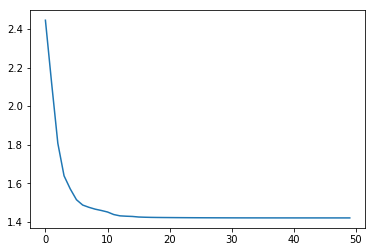

In [104]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

In [95]:
mid1 = g.render_midi(context, f=2)
mid2 = g.render_midi(context, f=3)
x_test = np.stack([midi.encode(context, m) for m in [mid1,mid2]])

WARNING type not == 0
WARNING type not == 0


In [96]:
latent = encoder.predict(x_test)
latent.shape

(2, 1000)

In [85]:
latent.shape

(2, 1000)

In [86]:
maxx = np.maximum(latent[0],latent[1])
maxx.shape

(1000,)

In [87]:
latent[0].shape

(1000,)

In [105]:
# arrays = decoder.predict(np.stack([latent[1]]))
arrays = auto.predict(x_train[:1])
arrays.shape

(1, 500, 4)

In [106]:
mid = midi.decode_track(context, arrays[0])

 [INFO] : 
 |  len, max_t
 |  9.78020833333333
 |  10.0


In [107]:
dn = config.export_dir
io.export_midifile(mid1, dn + 'mid1.mid')
# io.export_midifile(mid2, dn + 'mid2.mid')
io.export_midifile(mid, dn + 'mid_generated.mid')

In [91]:
mid

<midi file None type 1, 1 tracks, 1688 messages>

In [92]:
mid

<midi file None type 1, 1 tracks, 1688 messages>